# Presentation : Conformal prediction implementation in River

- BOGGIO Richard
- MDIHI Samy
- VERON Marc

## Modules imports

Important to note that our custom modules have to be imported manually

In [1]:
# Existing in River
from river import datasets, metrics, stream
from river import tree, utils
from river import optim
from river import stats 
from river import preprocessing

# Not existing in River
import conf.ACP
import conf.CP
import conf.gaussian
import time_series
import time_series.evaluates
from time_series.holt_winters import HoltWinters
from time_series.hoeffding_horizon import HoeffdingTreeHorizon
from time_series.evaluates import _iter_with_horizon

# Other 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import timeit
import time
from scipy.stats import norm
from ipywidgets import widgets, interact

Equivalent of norm.ppf in River : 

In [2]:
# Get a normal distribution
normal_dist = optim.initializers.Normal(mu=0, sigma=1, seed=42)
big_dist = normal_dist(shape=500000)

# confidence level
alpha = 0.975
# Compute with river
rolling_quantile = stats.Quantile(alpha)
for x in big_dist:
    _ = rolling_quantile.update(x)

# Check equivalence
print(f"with Scipy : {norm.ppf(alpha):.3f}")
print(f"with River : {rolling_quantile.get():.3f}")

with Scipy : 1.960
with River : 1.960


## Airline passengers dataset

In [27]:
dataset = datasets.AirlinePassengers()

## Defining the forecasting model

In [28]:
model = HoltWinters(
        alpha=0.3,
        beta=0.1,
        gamma=0.6,
        seasonality=12,
        multiplicative=True
        )

In [29]:
calib_period = 100
metric = metrics.MAE()
interval = conf.gaussian.Gaussian(window_size=calib_period, alpha=0.10)

In [30]:
time_series.evaluate(
        dataset,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )


(+1  MAE: 5.267265
 +2  MAE: 6.749827
 +3  MAE: 8.141309
 +4  MAE: 9.371405
 +5  MAE: 10.346176
 +6  MAE: 10.921248
 +7  MAE: 11.159352
 +8  MAE: 10.897803
 +9  MAE: 10.368661
 +10 MAE: 9.729828
 +11 MAE: 9.339404
 +12 MAE: 9.445909,
 +1  (106.65171146659074, 100.26694700020244)
 +2  (106.98687410190536, 99.7498808826684)
 +3  (107.39272979164082, 99.28809314480117)
 +4  (107.87081984067066, 98.92619172551491)
 +5  (108.1058702573912, 98.41364361501773)
 +6  (108.18362165148957, 97.91545114765748)
 +7  (108.04330613229105, 97.54889787378606)
 +8  (107.88680482950066, 97.32448696465575)
 +9  (107.57727646261051, 97.2409326171169)
 +10 (107.43285294272182, 97.16572693938618)
 +11 (107.57541904986789, 97.21869466994451)
 +12 (108.04240536266327, 97.174500031178))

In [31]:
dir(conf)

['ACP',
 'AdaptativeConformalPrediction',
 'CP',
 'ConformalPrediction',
 'Gaussian',
 'Interval',
 'RegressionJackknife',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'gaussian',
 'jackknife']

In [32]:
dir(time_series)

['ForecastingInterval',
 'ForecastingMetric',
 'HoeffdingTreeHorizon',
 'HoltWinters',
 'HorizonAggMetric',
 'HorizonInterval',
 'HorizonMetric',
 'SNARIMAX',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_iter_with_horizon',
 'base',
 'evaluate',
 'evaluates',
 'get_iter_evaluate',
 'hoeffding_horizon',
 'holt_winters',
 'intervals',
 'iter_evaluate',
 'metrics',
 'snarimax']

In [33]:
list_x, list_y, list_y_pred, list_metrics, list_interval = time_series.get_iter_evaluate(
        dataset,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )

In [34]:
list_interval

[+1  (106.65164884715999, 100.26700961963316)
 +2  (106.98683293927695, 99.74992204529678)
 +3  (107.39270824949237, 99.28811468694953)
 +4  (107.87080964885928, 98.92620191732624)
 +5  (108.10586126903438, 98.41365260337456)
 +6  (108.18360541266115, 97.91546738648584)
 +7  (108.04328247424355, 97.54892153183356)
 +8  (107.88677470487997, 97.32451708927644)
 +9  (107.57725395806244, 97.24095512166497)
 +10 (107.43283893927473, 97.16574094283321)
 +11 (107.57541590593357, 97.2186978138788)
 +12 (108.04241343532735, 97.17449195851387),
 +1  (106.65164884715999, 100.26700961963316)
 +2  (106.98683293927695, 99.74992204529678)
 +3  (107.39270824949237, 99.28811468694953)
 +4  (107.87080964885928, 98.92620191732624)
 +5  (108.10586126903438, 98.41365260337456)
 +6  (108.18360541266115, 97.91546738648584)
 +7  (108.04328247424355, 97.54892153183356)
 +8  (107.88677470487997, 97.32451708927644)
 +9  (107.57725395806244, 97.24095512166497)
 +10 (107.43283893927473, 97.16574094283321)
 +11 (10

## Electricity prices dataset

In [35]:
elec_prices = pd.read_csv("Prices_2016_2019_extract.csv", index_col=0, parse_dates=True)

In [12]:
elec_prices.tail(5)

,Spot,hour,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,lag_24_0,...,lag_168_15,lag_168_16,lag_168_17,lag_168_18,lag_168_19,lag_168_20,lag_168_21,lag_168_22,lag_168_23,conso
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,46.00,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,69600.0
2019-12-31 20:00:00,42.20,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,66000.0
2019-12-31 21:00:00,39.74,21.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,63600.0
2019-12-31 22:00:00,38.88,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,64800.0
2019-12-31 23:00:00,37.37,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,67500.0


In [13]:
elec_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34896 entries, 2016-01-08 00:00:00 to 2019-12-31 23:00:00
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Spot        34896 non-null  float64
 1   hour        34896 non-null  float64
 2   dow_0       34896 non-null  float64
 3   dow_1       34896 non-null  float64
 4   dow_2       34896 non-null  float64
 5   dow_3       34896 non-null  float64
 6   dow_4       34896 non-null  float64
 7   dow_5       34896 non-null  float64
 8   dow_6       34896 non-null  float64
 9   lag_24_0    34896 non-null  float64
 10  lag_24_1    34896 non-null  float64
 11  lag_24_2    34896 non-null  float64
 12  lag_24_3    34896 non-null  float64
 13  lag_24_4    34896 non-null  float64
 14  lag_24_5    34896 non-null  float64
 15  lag_24_6    34896 non-null  float64
 16  lag_24_7    34896 non-null  float64
 17  lag_24_8    34896 non-null  float64
 18  lag_24_9    34896 non-null  flo

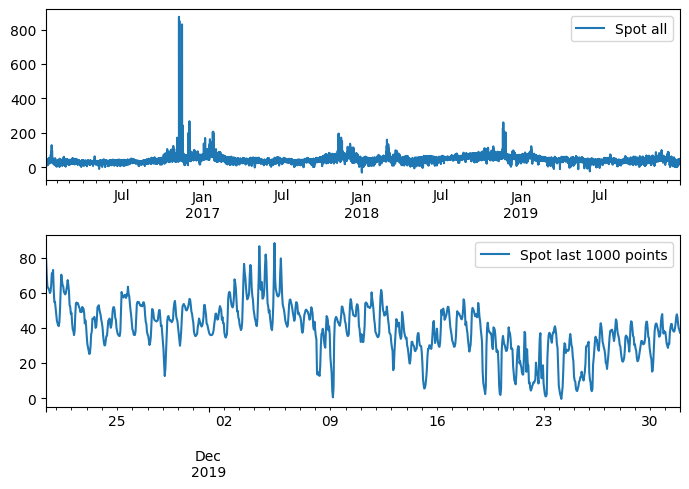

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7,5))
elec_prices[["Spot"]].plot(ax=ax1)
elec_prices[["Spot"]].iloc[-1000:,:].plot(ax=ax2)
ax1.xaxis.label.set_visible(False)
ax1.legend(["Spot all"])
ax2.xaxis.label.set_visible(False)
ax2.legend(["Spot last 1000 points"])
fig.tight_layout()

Defining the features X and the target label y

In [24]:
X, y = elec_prices.drop("Spot",axis=1), elec_prices[["Spot"]]

In [4]:
def run (model: time_series.base.Forecaster,
         stream_dataset, 
         metric=metrics.MAE(), 
         interval=conf.gaussian.Gaussian(window_size=1000, alpha=0.10),
         horizon=1,
         step=1, 
         verbose=True,
         plot=[]
        ):
    """Run the model on the dataset, and return the prediction with interval

    Parameters
    ----------
    model : tree.HoeffdingAdaptiveTreeRegressor
        the tree model
    dataset : _type_
        _description_
    cache_key : _type_
        _description_
    step : int, optional
        _description_, by default 1
    verbose : bool, optional
        _description_, by default True

    Returns
    -------
    _type_
        _description_
    """
    start = time.time()   

    # Defining the metric for the horizon
    horizon_metric = time_series.HorizonMetric(metric)
    # Defining the interval for a certain horizon
    horizon_interval = time_series.HorizonInterval(interval)
    
    # Defining the receiving list to output
    list_y = []
    list_yh = []
    list_ypred = []
    list_metric = []
    list_interval = []
    i = 0

    ##############################################################################
    # Pre-train the model
    ##############################################################################

    # Initialize the dataset from the beginning to get the grace period
    steps = _iter_with_horizon(stream_dataset, horizon)

    # Pre train the model on a defined quantities of sample "grace_periode"
    # Set the grace period as the max between horizon and the interval.window_size
    grace_period = max(horizon, interval.window_size)

    # Go over the grace_period to fit the model
    for t in range(grace_period):
        x, y, x_horizon, y_horizon = next(steps)
        model.learn_one(y=y, x=x)  # type: ignore
        if t >= interval.window_size:
            break


    ##############################################################################
    # Get first residuals series with the pre-trained model
    ##############################################################################

    # Reinitialize the dataset from the beginning to get the grace period
    # And initialize the interval window
    # TODO : being able to predict_many. Would be easier
    steps = _iter_with_horizon(stream_dataset, horizon)
    for _ in range(grace_period):
        x, y, x_horizon, y_horizon = next(steps)
        # Get the residual that will be used for calibration
        # calibration predictions (subset of training points)
        y_pred = model.forecast(horizon, xs=x_horizon)
        # Initializing the interval for each horizon
        horizon_interval.update(y_horizon, y_pred)


    ##############################################################################
    # Forecast with intervals and learn
    ##############################################################################

    # No reinitialisation of the dataset since we begin from where we stopped 
    # at the pre-train stage
    i=0
    for x, y, x_horizon, y_horizon in steps:
        # Predicting future values until a certain horizon
        y_pred = model.forecast(horizon, xs=x_horizon)
        # Updating the metric
        horizon_metric.update(y_horizon, y_pred)
        # Updating the interval for each horizon
        horizon_interval.update(y_horizon, y_pred)
        # Train the model
        model.learn_one(y=y, x=x)  # type: ignore



        # Incremente the list of metric values
        if (i+1)%step==0:
            list_metric.append(horizon_metric.get())
            list_interval.append(horizon_interval.get())
            list_y.append(y)
            list_yh.append(y_horizon)
            list_ypred.append(y_pred)

            if verbose:
                print(f"{i+1} samples : full = {list_metric[-1][0]:0.2f}")
        i += 1
    end = time.time()
    if verbose:
        print(f"\nStream passed in {end-start:.2f} seconds")


    return list_y, list_yh, list_ypred, list_metric, list_interval

**Custom horizon regression model : Hoeffding tree**

=> Impossible to fit apparently, always returning 0 as output. 

In [5]:
columns = [
    'hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6','lag_24_0',
    'lag_24_1','lag_24_2','lag_24_3', 'lag_24_4','lag_24_5','lag_24_6', 'lag_24_7','lag_24_8',
    'lag_24_9','lag_24_10','lag_24_11','lag_24_12','lag_24_13','lag_24_14','lag_24_15','lag_24_16',
    'lag_24_17','lag_24_18','lag_24_19','lag_24_20','lag_24_21','lag_24_22','lag_24_23','lag_168_0',
    'lag_168_1','lag_168_2','lag_168_3','lag_168_4','lag_168_5','lag_168_6','lag_168_7', 'lag_168_8',
    'lag_168_9','lag_168_10','lag_168_11','lag_168_12','lag_168_13','lag_168_14','lag_168_15','lag_168_16',
    'lag_168_17','lag_168_18','lag_168_19','lag_168_20','lag_168_21','lag_168_22','lag_168_23','conso','Spot'
]
col_dic = dict([(col, float) for col in columns])

In [6]:
steps_elec = stream.iter_csv("Prices_2016_2019_extract.csv",
                             target="Spot",
                             drop=["Date"],
                             converters=col_dic)

model = (
     preprocessing.StandardScaler() |
     time_series.HoeffdingTreeHorizon(
        grace_period=200,
        max_depth=5,
        model_selector_decay=0.3
        )
)


metric = metrics.MSE()

calib_period = 100
interval = conf.gaussian.Gaussian(window_size=calib_period, alpha=0.90)

In [7]:
time_series.evaluate(
        steps_elec,
        model,
        metric,
        interval,
        horizon=10,
        residual_calibration_period = calib_period
        )


(+1  MSE: 2,259.989338
 +2  MSE: 2,259.954848
 +3  MSE: 2,259.948571
 +4  MSE: 2,259.965348
 +5  MSE: 2,259.980296
 +6  MSE: 2,259.995038
 +7  MSE: 2,260.005058
 +8  MSE: 2,260.016078
 +9  MSE: 2,260.029919
 +10 MSE: 2,260.045923,
 +1  (33.491729892942764, -33.491729892942764)
 +2  (33.4916279969504, -33.4916279969504)
 +3  (33.4915736947973, -33.4915736947973)
 +4  (33.49158383801562, -33.49158383801562)
 +5  (33.49159144794332, -33.49159144794332)
 +6  (33.491595356583744, -33.491595356583744)
 +7  (33.491568476473894, -33.491568476473894)
 +8  (33.491400495492904, -33.491400495492904)
 +9  (33.49122260265586, -33.49122260265586)
 +10 (33.49093400331039, -33.49093400331039))

# Plot interval

In [8]:
def plot_interval(list_interval, list_y, range_toPlot):
    
    # Transform in array
    arr_interval = np.asarray(list_interval)
    arr_y = np.asarray(list_y)

    begin_at, end_at = range_toPlot

    fig, ax = plt.subplots()
    ax.plot(arr_y[begin_at:end_at], label="Water flow")
    ax.fill_between(np.arange(end_at-begin_at), 
                    arr_interval[begin_at:end_at].squeeze(1)[:,0], 
                    arr_interval[begin_at:end_at].squeeze(1)[:,1], 
                    color='b', alpha=.1)
    ax.set_title((f"{interval.__class__.__name__} interval at "
                    f"{interval.alpha*100:.0f}% for {model.__class__.__name__} "
                    f"on {dataset.__class__.__name__}"
                    ))
    fig.tight_layout()
    ax.plot()
    return True


# Gaussian Interval

**Back to Holding, on bigger dataset : WaterFlow**

In [9]:
dataset = datasets.WaterFlow()

model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )

metric = metrics.MSE()

calib_period = 100
alpha=0.05
interval = conf.gaussian.Gaussian(window_size=calib_period, alpha=alpha)

# Run and get all the relevant lists
plot_zoom = [180,700]
plot_full = [0,1166]
list_y, _, _, list_metric, list_interval = run(model, dataset, metric, interval, horizon=1)

1 samples : full = 2.33
2 samples : full = 25.95
3 samples : full = 17.36
4 samples : full = 15.06
5 samples : full = 16.18
6 samples : full = 13.96
7 samples : full = 19.18
8 samples : full = 176.66
9 samples : full = 427.46
10 samples : full = 506.65
11 samples : full = 467.15
12 samples : full = 478.55
13 samples : full = 456.37
14 samples : full = 431.79
15 samples : full = 409.95
16 samples : full = 384.34
17 samples : full = 361.87
18 samples : full = 341.92
19 samples : full = 324.97
20 samples : full = 308.79
21 samples : full = 294.19
22 samples : full = 280.84
23 samples : full = 268.70
24 samples : full = 257.67
25 samples : full = 247.44
26 samples : full = 237.93
27 samples : full = 229.12
28 samples : full = 220.94
29 samples : full = 213.33
30 samples : full = 206.23
31 samples : full = 199.59
32 samples : full = 193.37
33 samples : full = 187.53
34 samples : full = 182.02
35 samples : full = 176.85
36 samples : full = 171.98
37 samples : full = 167.34
38 samples : full 

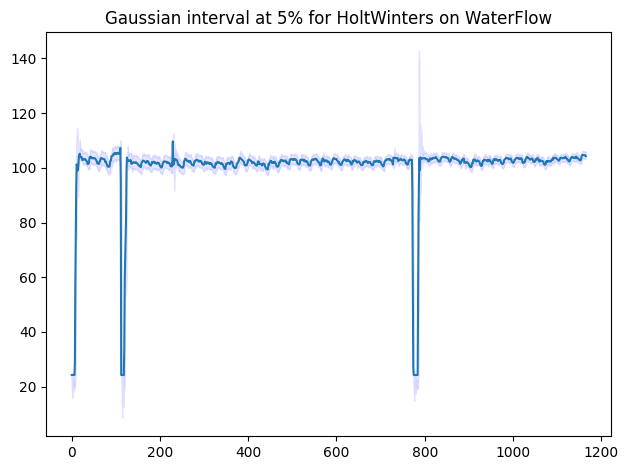

In [10]:
_ = plot_interval(list_interval,list_y,plot_full)

True

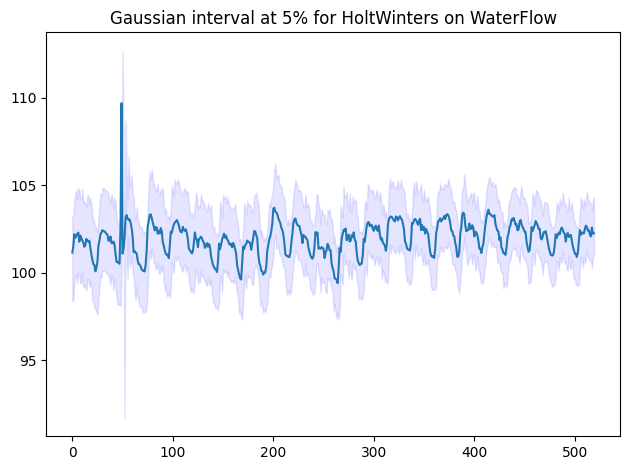

In [11]:
plot_interval(list_interval,list_y,plot_zoom)

[]

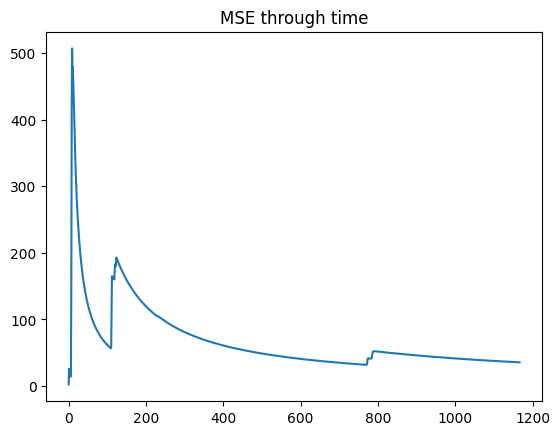

In [12]:
arr_metrics = np.asarray(list_metric)
plt.plot(arr_metrics[:,0])
plt.title("MSE through time")
plt.plot()

# Conformal Prediction

In [13]:
dataset = datasets.WaterFlow()

model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )

metric = metrics.MSE()

calib_period = 100
alpha=0.05
interval = conf.CP.ConformalPrediction(window_size=calib_period, alpha=alpha)

list_y, _, _, list_metric, list_interval = run(model, dataset, metric, interval, horizon=1)

1 samples : full = 2.33
2 samples : full = 25.95
3 samples : full = 17.36
4 samples : full = 15.06
5 samples : full = 16.18
6 samples : full = 13.96
7 samples : full = 19.18
8 samples : full = 176.66
9 samples : full = 427.46
10 samples : full = 506.65
11 samples : full = 467.15
12 samples : full = 478.55
13 samples : full = 456.37
14 samples : full = 431.79
15 samples : full = 409.95
16 samples : full = 384.34
17 samples : full = 361.87
18 samples : full = 341.92
19 samples : full = 324.97
20 samples : full = 308.79
21 samples : full = 294.19
22 samples : full = 280.84
23 samples : full = 268.70
24 samples : full = 257.67
25 samples : full = 247.44
26 samples : full = 237.93
27 samples : full = 229.12
28 samples : full = 220.94
29 samples : full = 213.33
30 samples : full = 206.23
31 samples : full = 199.59
32 samples : full = 193.37
33 samples : full = 187.53
34 samples : full = 182.02
35 samples : full = 176.85
36 samples : full = 171.98
37 samples : full = 167.34
38 samples : full 

True

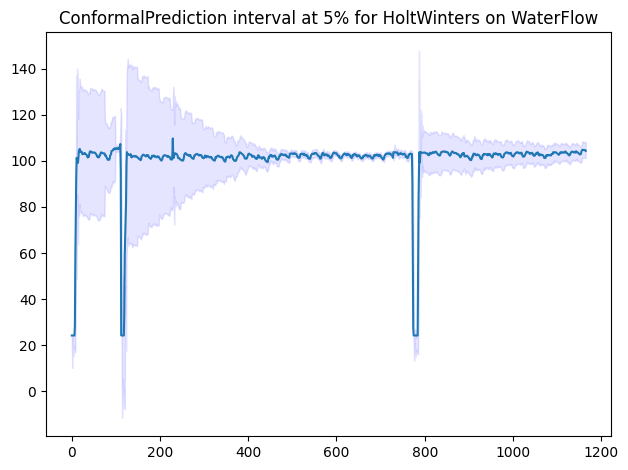

In [14]:
plot_interval(list_interval,list_y,plot_full)

# Adaptative Conformal Prediction

In [15]:
dataset = datasets.WaterFlow()

model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )

metric = metrics.MSE()

calib_period = 100
alpha=0.05
interval = conf.ACP.AdaptativeConformalPrediction(window_size=calib_period, gamma=0.002, alpha=alpha)

# Run and get all the relevant lists
list_y, list_yh, list_ypred, list_metric, list_interval = run(model, dataset, metric, interval, horizon=1,verbose=False)

True

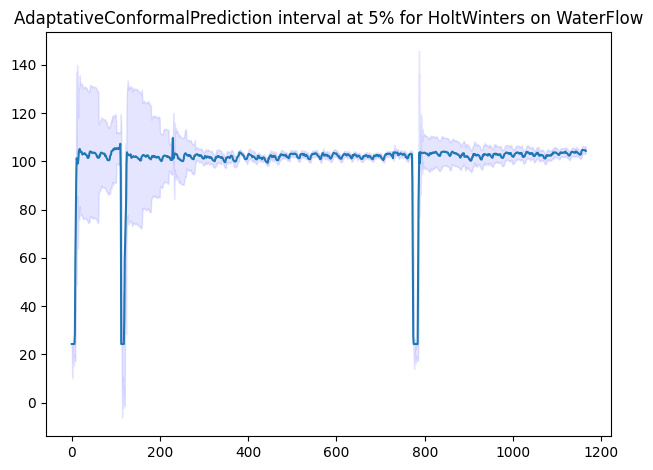

In [16]:
plot_interval(list_interval,list_y,plot_full)

In [17]:
tab_gamma = (0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09)


In [36]:
def plot_gamma_alpha(alpha,gamma):
        zoom = True
        dataset = datasets.WaterFlow()
        model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )
        metric = metrics.MSE()
        calib_period = 100
        interval = conf.ACP.AdaptativeConformalPrediction(window_size=calib_period, gamma=gamma, alpha=alpha)

        # Run and get all the relevant lists
        list_y, _, _, _, list_interval = run(model, dataset, metric, interval, horizon=1,verbose=False)

        if zoom:
                _ = plot_interval(list_interval,list_y,plot_zoom)
        else:

                _ = plot_interval(list_interval,list_y,plot_full)

In [37]:
widgets.interactive(plot_gamma_alpha,
                    alpha=widgets.FloatSlider(value=0.05,
                                              min=0.01,
                                              max=0.2,
                                              step=0.01,
                                              readout_format='.2f'),
                    gamma=widgets.FloatSlider(value=0.007,
                                              min=0.004,
                                              max=0.01,
                                              step=0.0001,
                                              readout_format='.6f')
)

interactive(children=(FloatSlider(value=0.05, description='alpha', max=0.2, min=0.01, step=0.01), FloatSlider(…